In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [350]:
file_path = '/Users/egeakguc/Desktop/dt/Tasarım2'
data = pd.read_csv('data.csv')



# Converting 'Date' to datetime format and inspect the data
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
print(data.head())




        Date Country/Region Name  Downloads  Store Revenue  Active Users  \
0 2023-11-05              Brazil       4406           1974         24963   
1 2023-11-05               India       3323             62         24829   
2 2023-11-05               Egypt       1873             55         10182   
3 2023-11-05            Thailand       1386            309          7133   
4 2023-11-05              Turkey       1234            505         20736   

   Avg Time / User  
0            10016  
1             6731  
2            14708  
3             2674  
4             7853  


In [351]:
ltv_by_country = data.groupby('Country/Region Name').apply(lambda x: x['Store Revenue'].sum() / x['Active Users'].sum())
print("Historical LTV by Country:")
print(ltv_by_country)


Historical LTV by Country:
Country/Region Name
Brazil            0.035773
Canada            5.194480
Colombia          0.018843
Egypt             0.007212
France            0.603740
Germany           0.287059
India             0.003009
Indonesia         0.012877
Malaysia          0.088254
Mexico            0.096864
Portugal          0.187690
Spain             0.334943
Thailand          0.028811
Turkey            0.019247
United Kingdom    7.901214
United States     1.217583
Vietnam           0.020763
dtype: float64


In [352]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def perform_regression(country_data):
    X = country_data[['Avg Time / User']]
    y = country_data['Store Revenue']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating and training the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Making predictions and evaluating the model
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Returning the results
    return model.coef_, model.intercept_, mse, r2


In [353]:
for country in data['Country/Region Name'].unique():
    print(f"{country}:")
    country_data = data[data['Country/Region Name'] == country]
    
    # Perform regression
    coefficients, intercept, mse, r2 = perform_regression(country_data)

    # Print the results
    print("Coefficients:", coefficients)
    print("Intercept:", intercept)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared:", r2)
    print("\n")


Brazil:
Coefficients: [-0.02145028]
Intercept: 2047.888381751609
Mean Squared Error (MSE): 14013.996377657639
R-squared: -0.16723385142773695


India:
Coefficients: [0.00603311]
Intercept: 59.94659813347546
Mean Squared Error (MSE): 1607.0823674513756
R-squared: -0.24118193346569017


Egypt:
Coefficients: [-0.00176748]
Intercept: 77.44551540259778
Mean Squared Error (MSE): 332.2367240040159
R-squared: -0.9226662268750923


Thailand:
Coefficients: [-0.00580226]
Intercept: 251.99543616554712
Mean Squared Error (MSE): 1926.218906670066
R-squared: -0.11486485777542366


Turkey:
Coefficients: [-0.00404185]
Intercept: 459.7300185803594
Mean Squared Error (MSE): 6850.257062278532
R-squared: -0.07474568898474576


Indonesia:
Coefficients: [-0.0101067]
Intercept: 396.384281417422
Mean Squared Error (MSE): 17054.10442144164
R-squared: -1.2774759649154985


Malaysia:
Coefficients: [-0.01680497]
Intercept: 744.3652892020575
Mean Squared Error (MSE): 45151.14061875222
R-squared: -5.501656061543455


Due to the nature of the data, multiple linear regression does not seem to work adequately, 
so we apply different methods that deal with outliers and non-linearity better.

In [354]:
features = ['Downloads', 'Active Users', 'Avg Time / User'] 
X = data[features]
y = data['Store Revenue']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [363]:
from sklearn.ensemble import RandomForestRegressor

# Creating the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [356]:
from sklearn.metrics import mean_squared_error, r2_score

# Making predictions
predictions = rf_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Random Forest - Mean Squared Error: {mse}")
print(f"Random Forest - R-squared: {r2}")


Random Forest - Mean Squared Error: 4588324.026008333
Random Forest - R-squared: 0.9461955998603775


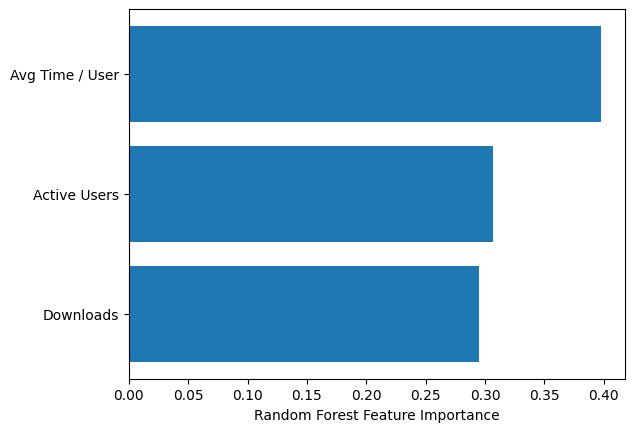

In [364]:
# Feature importance
feature_importance = rf_model.feature_importances_
sorted_idx = feature_importance.argsort()

plt.barh(features, feature_importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()


In [358]:
countries = data['Country/Region Name'].unique()

# Prepare a dictionary to store results
ltv_results = {}

for country in countries:
    country_data = data[data['Country/Region Name'] == country]

    # Historical LTV
    total_revenue_historic = country_data['Store Revenue'].sum()
    total_users_historic = country_data['Active Users'].sum()
    historical_ltv = total_revenue_historic / total_users_historic if total_users_historic else 0

    # Predicted LTV
    country_features = country_data[['Downloads', 'Active Users', 'Avg Time / User']]
    predicted_revenue = rf_model.predict(country_features).sum()
    predicted_ltv = predicted_revenue / total_users_historic if total_users_historic else 0

    # Growth Rate Calculation
    growth_rate = ((predicted_ltv - historical_ltv) / historical_ltv) * 100 if historical_ltv else 0

    # Storing results
    ltv_results[country] = {
        'Historical LTV': historical_ltv,
        'Predicted LTV': predicted_ltv,
        'Growth Rate (%)': growth_rate
    }

# Displaying the results
for country, metrics in ltv_results.items():
    print(f"{country}:")
    for key, value in metrics.items():
        print(f"   {key}: {value:.2f}")
    print("\n")


Brazil:
   Historical LTV: 0.04
   Predicted LTV: 0.04
   Growth Rate (%): 7.41


India:
   Historical LTV: 0.00
   Predicted LTV: 0.01
   Growth Rate (%): 355.07


Egypt:
   Historical LTV: 0.01
   Predicted LTV: 0.02
   Growth Rate (%): 189.31


Thailand:
   Historical LTV: 0.03
   Predicted LTV: 0.03
   Growth Rate (%): 12.80


Turkey:
   Historical LTV: 0.02
   Predicted LTV: 0.03
   Growth Rate (%): 45.24


Indonesia:
   Historical LTV: 0.01
   Predicted LTV: 0.09
   Growth Rate (%): 628.29


Malaysia:
   Historical LTV: 0.09
   Predicted LTV: 0.09
   Growth Rate (%): 0.80


Vietnam:
   Historical LTV: 0.02
   Predicted LTV: 0.03
   Growth Rate (%): 24.75


United States:
   Historical LTV: 1.22
   Predicted LTV: 1.09
   Growth Rate (%): -10.52


Mexico:
   Historical LTV: 0.10
   Predicted LTV: 0.11
   Growth Rate (%): 10.14


United Kingdom:
   Historical LTV: 7.90
   Predicted LTV: 7.40
   Growth Rate (%): -6.39


Colombia:
   Historical LTV: 0.02
   Predicted LTV: 0.07
   Grow

In [359]:
from sklearn.ensemble import GradientBoostingRegressor

# Prepare features and target variable
X = data[['Downloads', 'Active Users', 'Avg Time / User']]  # Adjust features as needed
y = data['Store Revenue']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=2000, random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
predictions = gb_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Gradient Boosting - Mean Squared Error:", mse)
print("Gradient Boosting - R-squared:", r2)


Gradient Boosting - Mean Squared Error: 1140039.171808277
Gradient Boosting - R-squared: 0.9866314751471075


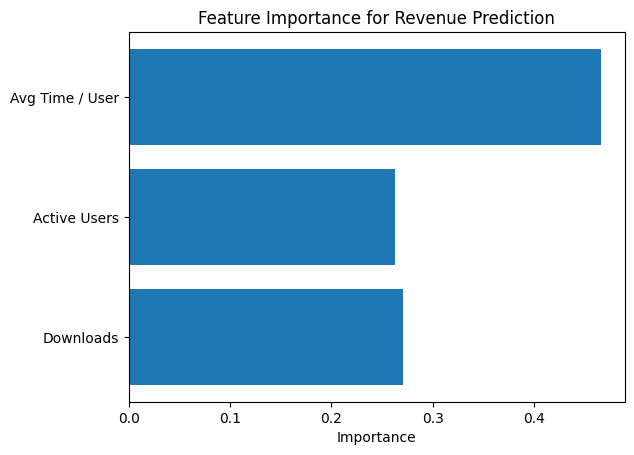

In [360]:
# Plotting feature importance
feature_importance = gb_model.feature_importances_
plt.barh(X.columns, feature_importance)
plt.xlabel('Importance')
plt.title('Feature Importance for Revenue Prediction')
plt.show()


In [361]:
for country in data['Country/Region Name'].unique():
    country_data = data[data['Country/Region Name'] == country]
    X_country = country_data[['Downloads', 'Active Users', 'Avg Time / User']]
    y_country = country_data['Store Revenue']

    # Training a model for each country
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_country, y_country)

    future_revenue = model.predict(X_country).sum()
    print(f"Predicted total future revenue for {country}: {future_revenue}")


Predicted total future revenue for Brazil: 38908.0
Predicted total future revenue for India: 2014.0
Predicted total future revenue for Egypt: 1126.0
Predicted total future revenue for Thailand: 4558.0
Predicted total future revenue for Turkey: 9078.999999999998
Predicted total future revenue for Indonesia: 7334.999999999999
Predicted total future revenue for Malaysia: 12931.999999999998
Predicted total future revenue for Vietnam: 3305.0
Predicted total future revenue for United States: 761032.0000000001
Predicted total future revenue for Mexico: 7996.0
Predicted total future revenue for United Kingdom: 102857.99999999999
Predicted total future revenue for Colombia: 900.0000000000001
Predicted total future revenue for Portugal: 5550.0
Predicted total future revenue for France: 23243.999999999996
Predicted total future revenue for Canada: 32371.999999999996
Predicted total future revenue for Germany: 63871.99999999999
Predicted total future revenue for Spain: 6310.0
